<a href="https://colab.research.google.com/github/bhargav23/EIP-Assignment-5/blob/master/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/Temp/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,87859,87859,87859,87859,87859,87859,87859,87859,87859
unique,2,3,5,4,3,3,4,3,13573
top,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/4058.jpg
freq,49644,47555,26380,39264,44598,37309,30757,43609,216


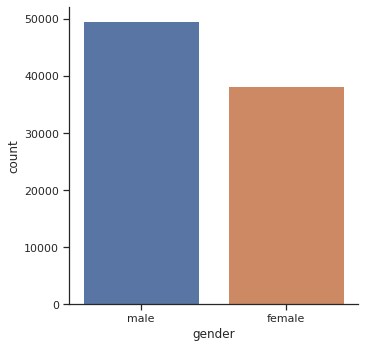

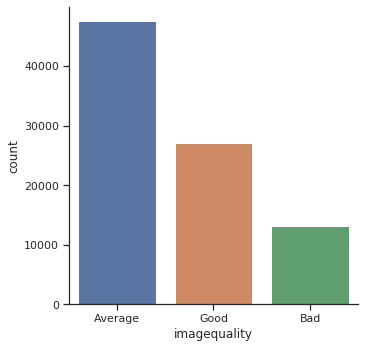

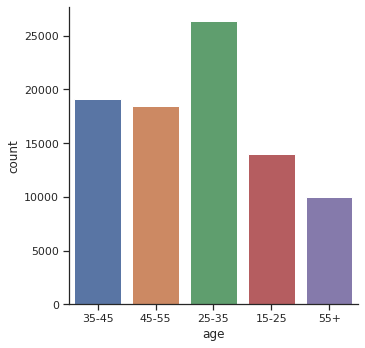

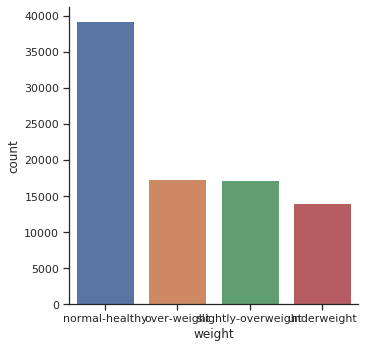

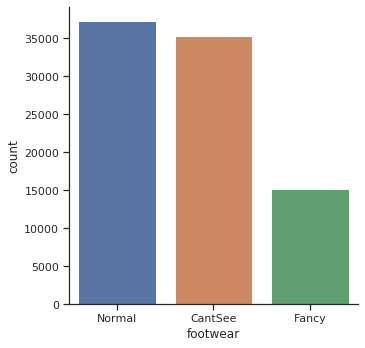

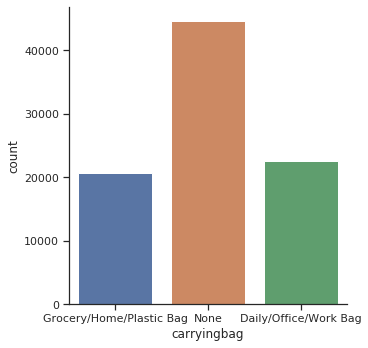

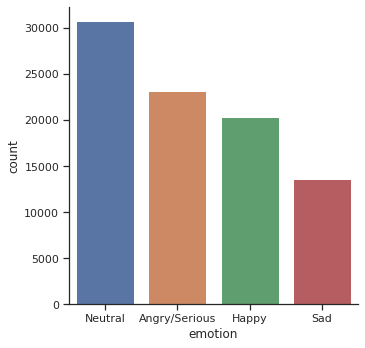

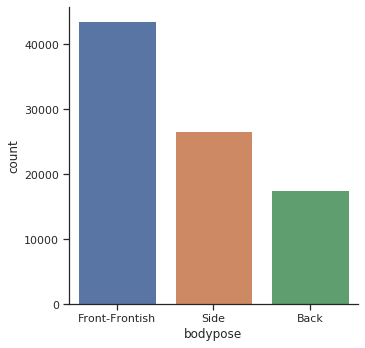

In [0]:
import numpy as np
import pandas as pd

df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df["image_path"]
df.head()

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

o = df[(df.emotion!='Neutral')]
for i in range(5):df = df.append(o)
o = df[(df.bodypose=='Back')]
df = df.append(o)
o = df[(df.bodypose!='Front-Frontish')]
df = df.append(o)
o = df[(df.age=='55+') | (df.age=='45-55')]
df = df.append(o)
o = df[(df.carryingbag=='Grocery/Home/Plastic Bag')]
for i in range(2): df = df.append(o)
o = df[(df.weight=='over-weight') | (df.weight=='underweight')]
for i in range(2): df = df.append(o)
sns.catplot(x="gender", kind="count", data=df)
sns.catplot(x="imagequality", kind="count", data=df)
sns.catplot(x="age", kind="count", data=df)
sns.catplot(x="weight", kind="count", data=df)
sns.catplot(x="footwear", kind="count", data=df)
sns.catplot(x="carryingbag", kind="count", data=df)
sns.catplot(x="emotion", kind="count", data=df)
sns.catplot(x="bodypose", kind="count", data=df)
df.describe()


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((74680, 28), (13179, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
987,resized/988.jpg,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
11666,resized/11668.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
1967,resized/1968.jpg,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1
1943,resized/1944.jpg,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
1763,resized/1764.jpg,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [0]:
def mymodel():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))


    return model

In [0]:
backbone = mymodel()

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-

In [0]:
model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

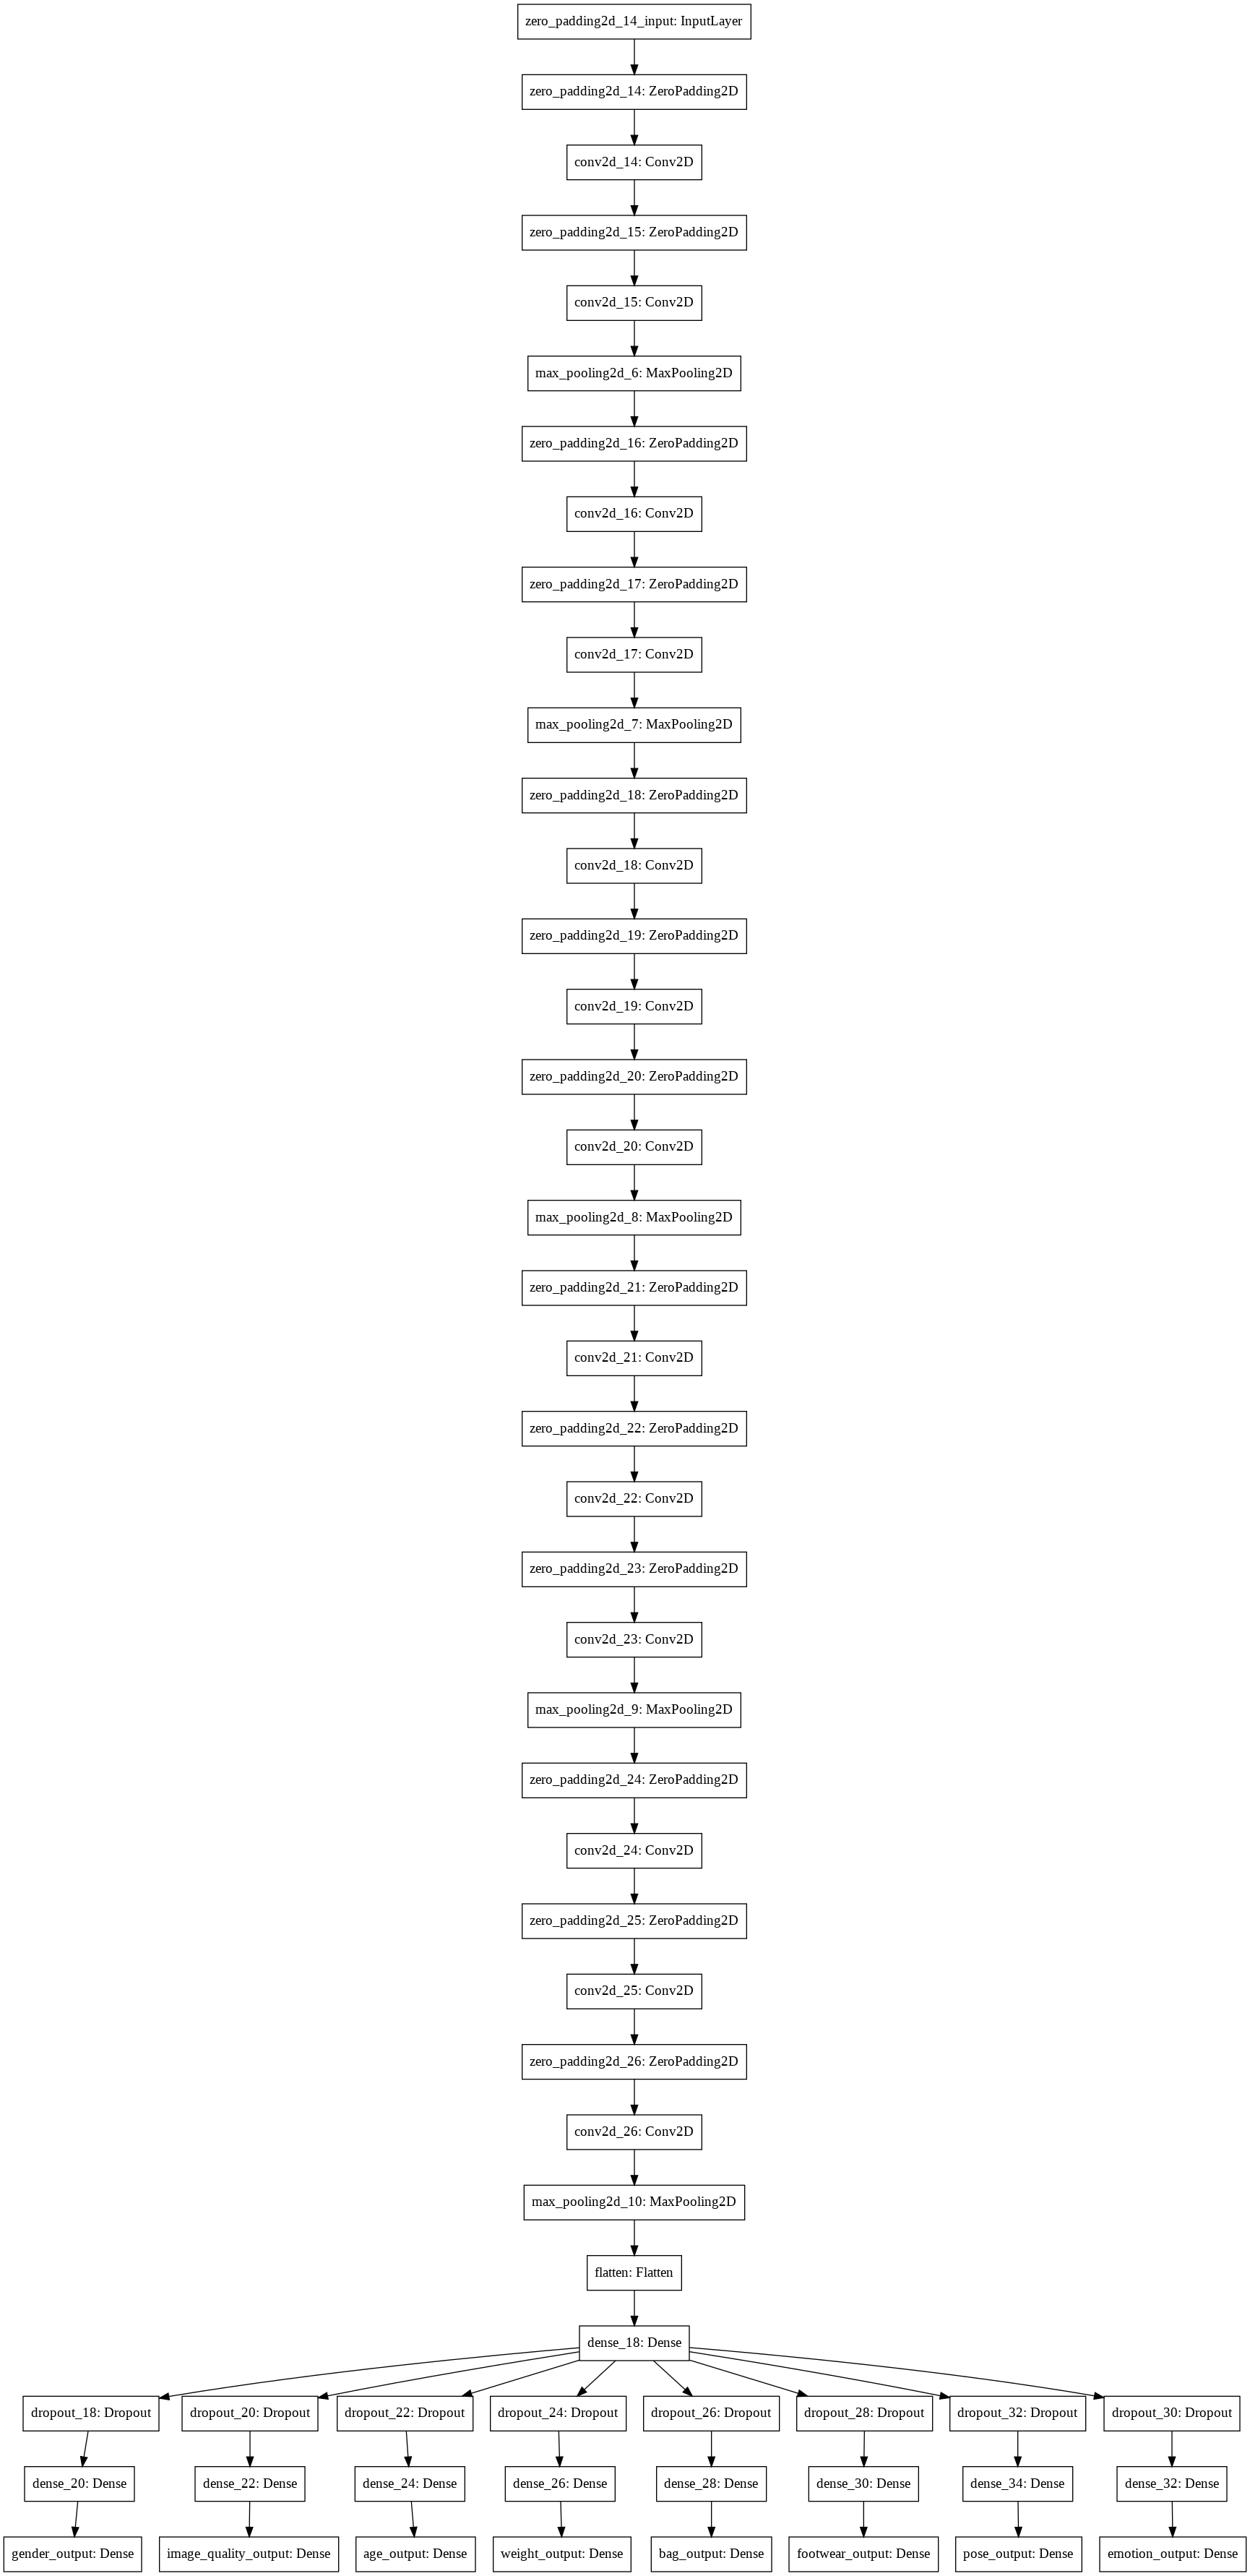

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')


In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2333/2333 [==============================] - 300s 128ms/step - loss: 8.8078 - gender_output_loss: 0.6708 - image_quality_output_loss: 0.9742 - age_output_loss: 1.5472 - weight_output_loss: 1.2838 - bag_output_loss: 1.0332 - footwear_output_loss: 0.9342 - pose_output_loss: 1.0203 - emotion_output_loss: 1.3441 - gender_output_acc: 0.5731 - image_quality_output_acc: 0.5393 - age_output_acc: 0.3079 - weight_output_acc: 0.4473 - bag_output_acc: 0.5055 - footwear_output_acc: 0.5562 - pose_output_acc: 0.4971 - emotion_output_acc: 0.3509 - val_loss: 8.6501 - val_gender_output_loss: 0.6565 - val_image_quality_output_loss: 0.9560 - val_age_output_loss: 1.5207 - val_weight_output_loss: 1.2698 - val_bag_output_loss: 1.0178 - val_footwear_output_loss: 0.8924 - val_pose_output_loss: 0.9976 - val_emotion_output_loss: 1.3392 - val_gender_output_acc: 0.6177 - val_image_quality_output_acc: 0.

In [0]:
results = model.evaluate(valid_gen, verbose=1)

205/205 [==============================] - 35s 173ms/step


In [0]:
R = dict(zip(model.metrics_names, results))
for k, v in R.items():
    print(k, " : ", v )

loss  :  8.603082089307831
gender_output_loss  :  0.667629032018708
image_quality_output_loss  :  0.9590692203219344
age_output_loss  :  1.538370455183634
weight_output_loss  :  1.266672364676871
bag_output_loss  :  1.0111327671423191
footwear_output_loss  :  0.8217493313114818
pose_output_loss  :  1.0021456081692766
emotion_output_loss  :  1.3363132988534323
gender_output_acc  :  0.5973323170731707
image_quality_output_acc  :  0.5486280487804878
age_output_acc  :  0.32644817073170734
weight_output_acc  :  0.4532012195121951
bag_output_acc  :  0.5166920731707317
footwear_output_acc  :  0.6432926829268293
pose_output_acc  :  0.5083841463414634
emotion_output_acc  :  0.35327743902439024


In [0]:
R = dict(zip(model.metrics_names, results))
for k, v in R.items():
    print(k, " : ", v )

loss  :  7.612509849336412
gender_output_loss  :  0.6551890081829495
image_quality_output_loss  :  0.9722247295909457
age_output_loss  :  1.4056776291794246
weight_output_loss  :  0.9753220922417111
bag_output_loss  :  0.9076074928045272
footwear_output_loss  :  0.8809888068172667
pose_output_loss  :  0.9163971914185418
emotion_output_loss  :  0.899102885193295
gender_output_acc  :  0.5866319444444444
image_quality_output_acc  :  0.5513020833333333
age_output_acc  :  0.39913194444444444
weight_output_acc  :  0.6330729166666667
bag_output_acc  :  0.565625
footwear_output_acc  :  0.6046875
pose_output_acc  :  0.61484375
emotion_output_acc  :  0.7128472222222222
